In [346]:
from distutils.command import config

def random_search(problem, function_evaluations=10, **kwargs):

    history = []
    configs = []

    RANGES = GET_RANGES(problem) 

    for j in range(function_evaluations):
        config={}
        
        for i in RANGES:
            # If there is a condition, check if it holds.
            # If not, skip this hyperparameter
            if(condition(RANGES, config, i)):
                continue
            
            a = RANGES[i]['range'][0] 
            b = RANGES[i]['range'][1] 
            
            # If uniform
            if(RANGES[i]['sample']==0):
                if (RANGES[i]["type"] == 0):
                    value=np.random.choice(RANGES[i]['range']) 
                    config[i]=value  
                elif (RANGES[i]["type"] == 1):
                    value=np.random.uniform(a, b) 
                    config[i]=value
                else:
                    value=np.random.randint(a, b+1) 
                    config[i]=value
            # Else log        
            else:
                value=np.random.uniform(np.log(a), np.log(b)) 
                config[i]=np.exp(value) # exponentiate value back 
        configs.append(config)
        history.append(GET_CONFIG_PERFORMANCE(config))

    return history, configs

# Function for checking if hyperparameter has a condition and whether it holds
def condition(ranges, config, i):
        if('condition' in ranges[i]):
            if (ranges[i]['condition'](config) == False):
                return True

In [341]:
from utils import GET_CONFIG_PERFORMANCE, GET_RANGES, SampleType, ParamType,normal_dist # make sure to make use of ParamType and SampleType in your code
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import norm
from scipy import stats
import seaborn as sns
from scipy.stats import truncnorm

def tpe(problem, function_evaluations=150, random_warmup=30, gamma=0.2, n=3, **kwargs):

    RANGES = GET_RANGES(problem) 
    hyper_parameters=pd.DataFrame(columns=["configs","loss"])
    # Initial warm-up using random search
    for i in range(random_warmup):
        loss,configs=random_search(problem,function_evaluations=5) 
        hyper_parameters["configs"]=configs
        hyper_parameters["loss"]=loss

    sorted_loss_df=(hyper_parameters.sort_values(by=["loss"]))
    good_df, bad_df = good_bad(gamma, sorted_loss_df)
    
    #print(configs)
    df = pd.DataFrame(columns=RANGES.keys())
    df1 = pd.DataFrame(columns=RANGES.keys())
    configs = []
    loss_= []
    for i in range(10):
        config,proba=(sample(RANGES,good_df,bad_df,n))
        loss = GET_CONFIG_PERFORMANCE(config)
        df.loc[i]=proba
        configs.append(config)
        loss_.append(loss)
        df1.loc[i]=config
          
    df.plot(subplots=True, layout=(7,1))
    plt.show()
    plt.plot(df1["learning_rate"],loss_,'-bo')
    plt.show()
        
# Function for dividing samples into good and bad dataframes    
def good_bad(gamma, df):
    
    index_value=int(gamma*(df.shape[0]))
    good_dataframe = df.iloc[:index_value,:]
    bad_dataframe = df.iloc[index_value:df.shape[0],:]

    #remove all nan values
    # Splitting is done this way to cope with duplicate loss values.
    
    good_df=(good_dataframe["configs"].apply(pd.Series))
    bad_df=(bad_dataframe["configs"].apply(pd.Series))

    good_df["loss"]=good_dataframe["loss"]
    bad_df["loss"]=bad_dataframe["loss"]
    
    #print(good_df.describe(),bad_df.describe())
    
    return good_df.drop_duplicates(subset=["loss"]), bad_df.drop_duplicates(subset=["loss"])

# Function that constructs l(x) and samples from it
def sample(RANGES, good_df,bad_df, n):
    
    # List for testing samples
    samples = []
    config={}
    probabilities =[]
    for i in RANGES:  
        #print(i)
        x = good_df[i].dropna()
        y = bad_df[i].dropna()
     
        # If categorical, sample uniform
        if RANGES[i]['type'] == 0:
            sample =  np.random.choice(RANGES[i]['range'])
            samples.append(sample)
            config[i]=sample
            probabilities.append(0)

        else:
            #print(x,y)
            mean, sd = np.mean(x), np.std(x)
            mean_b, sd_b = np.mean(y), np.std(y)
            
            if(RANGES[i]['sample'] == 0):
                l_x = normal_dist(x, mean, sd)
                g_x = normal_dist(y, mean_b, sd_b )
            else:
                l_x = normal_dist(np.log(x), mean, sd)
                g_x = normal_dist(np.log(y), mean_b, sd_b)
                
            # Bounds indicate the truncated gaussians
            a,b = -np.inf, np.inf
            
            # Set prob of values x < a or x > b to '0'
            l_x[x < a], l_x[x > b] = 0, 0
            g_x[y < a], g_x[y > b] = 0, 0

            y_cum = np.cumsum(l_x) / l_x.sum()
            
            # n indicates candidate samples
            yrand = np.random.rand(n)
            sample = np.interp(yrand, y_cum, x)
            samples.append(sample)
            config[i]=sample[0]
            
            probability = (stats.norm.cdf(sample, loc=mean, scale=sd))
            probability_g_x = (stats.norm.cdf(sample, loc=mean_b, scale=sd_b))
            
            #print(probability,probability_g_x)
            probabilities.append((probability/probability_g_x)[0])

    # Added all the samples to a list to get some results   
    #print(probabilities)
    return config,probabilities

C:\Users\mally\anaconda3\envs\deep_learning_a0\lib\site-packages\scipy\stats\_distn_infrastructure.py:2168: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\mally\anaconda3\envs\deep_learning_a0\lib\site-packages\scipy\stats\_distn_infrastructure.py:2168: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\mally\anaconda3\envs\deep_learning_a0\lib\site-packages\scipy\stats\_distn_infrastructure.py:2168: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\mally\anaconda3\envs\deep_learning_a0\lib\site-packages\scipy\stats\_distn_infrastructure.py:2168: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
C:\Users\mally\anaconda3\envs\deep_learning_a0\lib\site-packages\scipy\stats\_distn_infrastructure.py:2168: RuntimeWarning: invalid value encountered in divide
  x = np.asarray

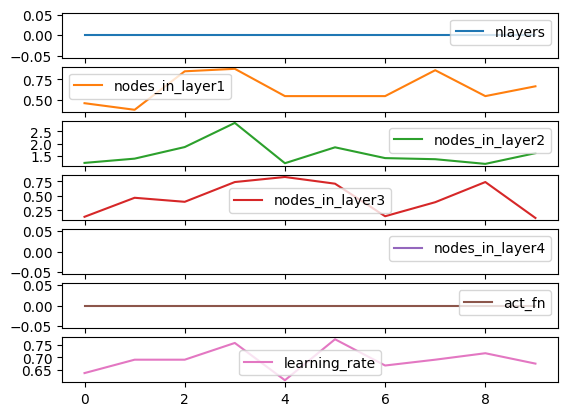

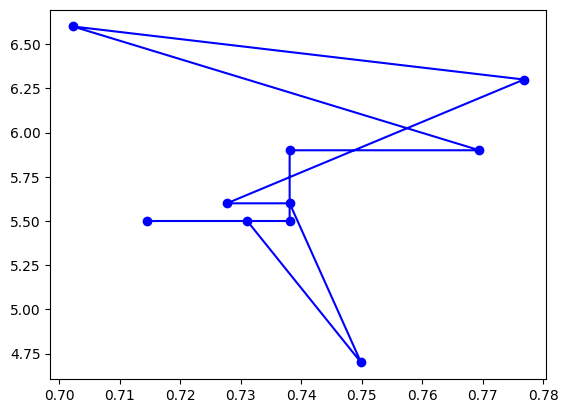

In [345]:
# This gives 1 sample per hyperparameter, since I used n=1 for now
tpe('bad_range')

[0.5 0.8 1.2 1.5 1.8 2.  2.2 2.5 2.7 2.8 3.  3.2 3.5 3.7 3.9 4.2 4.4 4.6
 4.9 5.2 5.4 5.6 6.3 7.3]


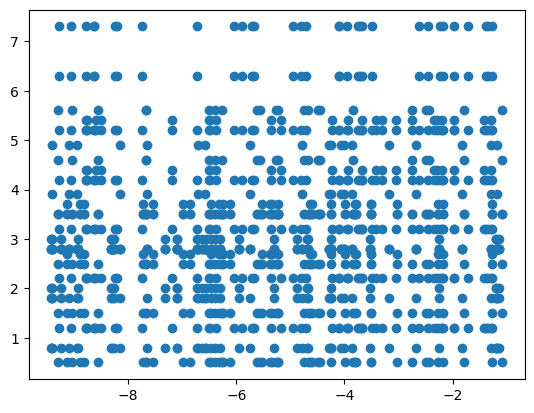

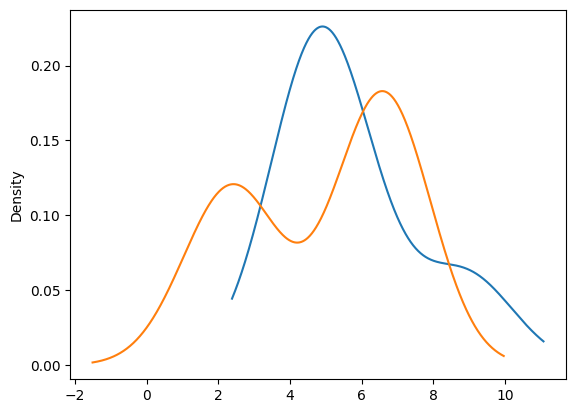

In [343]:
# Below is an example of what the mixture of truncated gaussians looks like for the hyperparameter 'nodes_in_layer_1'
# I warmed up and split the dataframe just like before
# Then I used the 'normal_dist' function to construct l(x), this gives us the points of the PDF
# Apparently dataframes have a built in plot function

gamma = 0.2

for i in range(5):
    loss,configs=random_search("good_range",function_evaluations=100) 
    
hyper_parameters=pd.DataFrame(columns=["configs","loss"])
hyper_parameters["configs"]=configs
hyper_parameters["loss"]=loss

sorted_loss_df=(hyper_parameters.sort_values(by=["loss"]))
good_df, bad_df = good_bad(gamma, sorted_loss_df)

print(sorted_loss_df["loss"].unique())
plt.scatter(hyper_parameters["configs"].apply(pd.Series)["learning_rate"],hyper_parameters["loss"])
plt.show()

mean = np.mean(good_df['learning_rate'])
sd = np.std(good_df['learning_rate'])

mean_b = np.mean(bad_df['learning_rate'])
sd_b = np.std(bad_df['learning_rate'])

# Construct l(x)
l_x = normal_dist(good_df['learning_rate'], mean, sd)
# Plot PDF of l(x)
l_x.plot(kind='density')

g_x = normal_dist(bad_df['learning_rate'], mean_b, sd_b)
# Plot PDF of l(x)
g_x.plot(kind='density')
plt.show()
# The output is as expected: since it is a mixture of truncated gaussians, we do not expect the 'bell curve'.
# We instead expect all Gaussians added together.

0.28445664090901096 0.5689352867223428


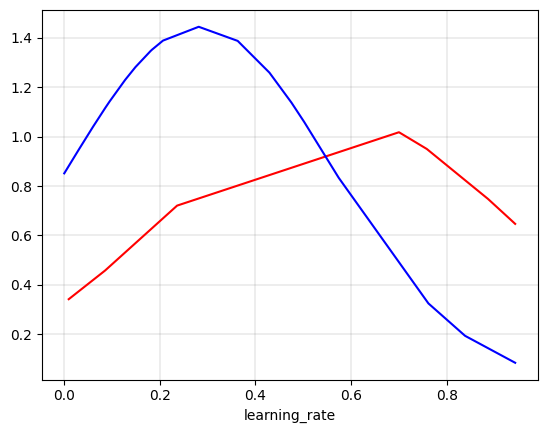

In [342]:
# Below is an example of what the mixture of truncated gaussians looks like for the hyperparameter 'nodes_in_layer_1'
# I warmed up and split the dataframe just like before
# Then I used the 'normal_dist' function to construct l(x), this gives us the points of the PDF
# Apparently dataframes have a built in plot function
from scipy.stats import norm
gamma = 0.3

hyper_parameters=pd.DataFrame(columns=["configs","loss"])
for i in range(5):
    loss,configs=random_search("bad_range",function_evaluations=10) 
    hyper_parameters["configs"]=configs
    hyper_parameters["loss"]=loss

sorted_loss_df=(hyper_parameters.sort_values(by=["loss"]))
good_df, bad_df = good_bad(gamma, sorted_loss_df)

mean = np.mean(good_df['learning_rate'])
sd = np.std(good_df['learning_rate'])

mean_b = np.mean(bad_df['learning_rate'])
sd_b = np.std(bad_df['learning_rate'])

print(mean_b,mean)
# Construct l(x)
import seaborn as sns
data = good_df['learning_rate']
fig, ax = plt.subplots()
pdf = stats.norm.pdf(data, loc=mean, scale=sd)
    # Plot pdf using sns.lineplot
ax = sns.lineplot(x=data, y=pdf, color="red", ax=ax)
    # Change face color and grid lines
ax.grid(which='major', linewidth='0.2', color='gray')

data = bad_df['learning_rate']
pdf = stats.norm.pdf(data, loc=mean_b, scale=sd_b)
    # Plot pdf using sns.lineplot
ax = sns.lineplot(x=data, y=pdf, color="blue", ax=ax)
    # Change face color and grid lines
ax.grid(which='major', linewidth='0.2', color='gray')

# The output is as expected: since it is a mixture of truncated gaussians, we do not expect the 'bell curve'.
# We instead expect all Gaussians added together.